# 17. Brownian Motion: Construction

**Goal:** Build Brownian motion from scaled random walks and visualize convergence.

**Donsker's Theorem (Functional CLT):** Let $S_n = X_1 + \cdots + X_n$ where $X_i$ are i.i.d. with mean 0 and variance 1. Define the rescaled process:
$$W^{(n)}(t) = \frac{S_{\lfloor nt \rfloor}}{\sqrt{n}}, \quad t \in [0, 1]$$
Then $W^{(n)} \Rightarrow B$ in distribution on $C[0,1]$, where $B$ is standard Brownian motion.

Brownian motion $B_t$ satisfies:
1. $B_0 = 0$
2. Independent increments: $B_t - B_s \perp B_u - B_v$ for disjoint intervals
3. Gaussian increments: $B_t - B_s \sim \mathcal{N}(0, t-s)$
4. Continuous sample paths a.s.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Scaled Random Walk Convergence

A simple symmetric random walk $S_n$ takes steps $\pm 1$ with equal probability.
After rescaling by $1/\sqrt{n}$ and interpolating, the path converges to Brownian motion.

We visualize this for increasing $n$: the jagged walk smooths into a continuous Gaussian process.

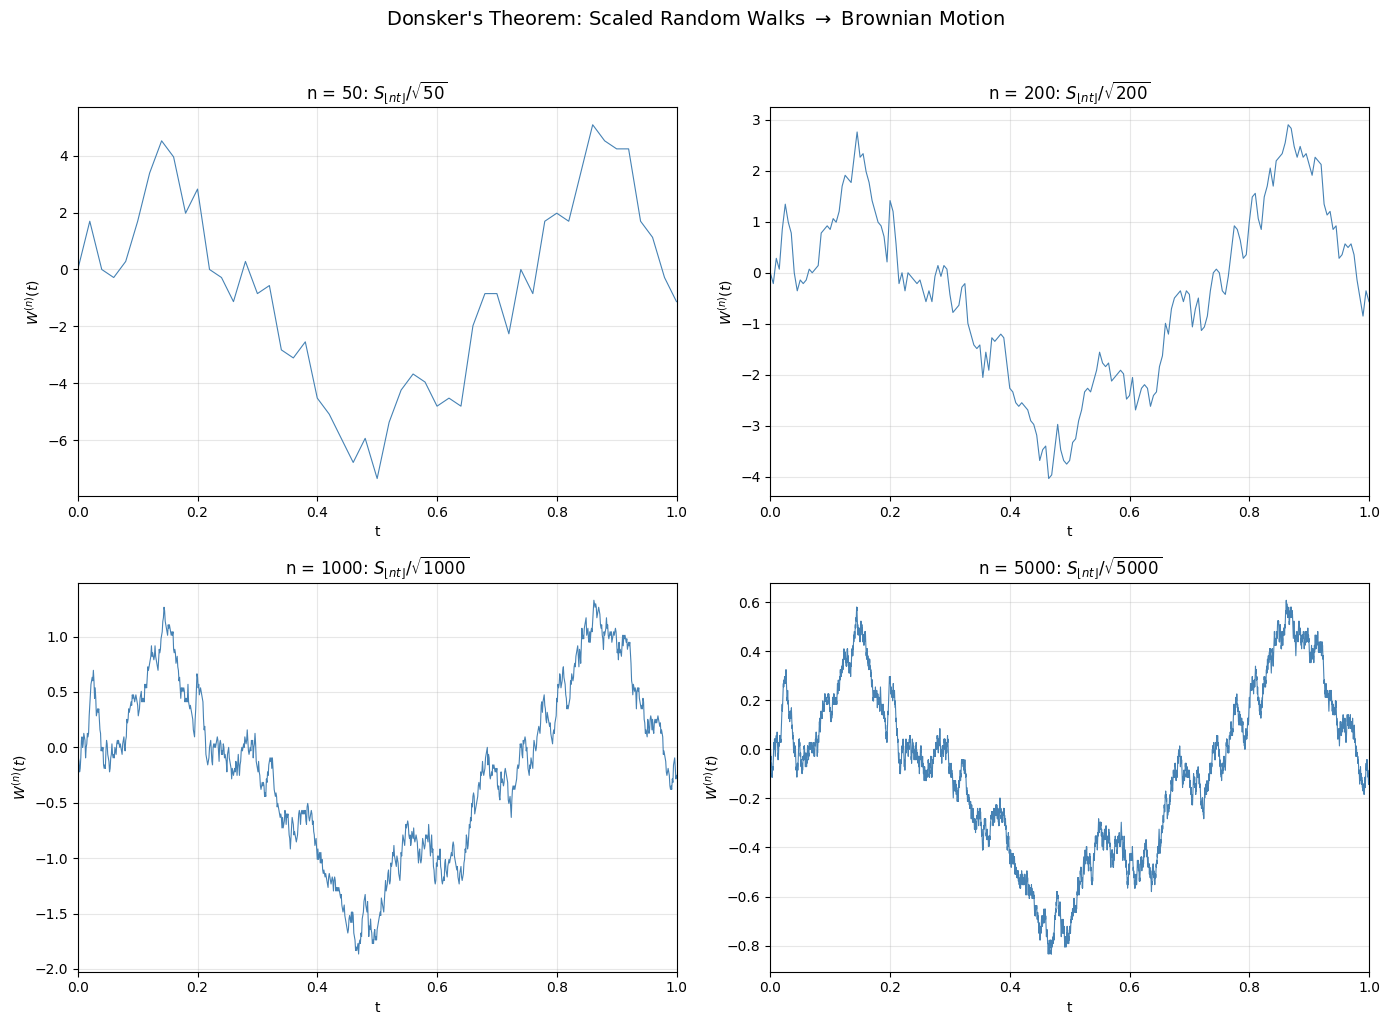

In [2]:
np.random.seed(42)

T = 1.0
n_values = [50, 200, 1000, 5000]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Use the same underlying randomness for visual coherence
# Generate finest random walk, then subsample
n_max = max(n_values)
steps_fine = np.random.choice([-1, 1], size=n_max)

for idx, n in enumerate(n_values):
    ax = axes[idx]
    # Subsample steps for this n
    ratio = n_max // n
    steps_n = np.array([steps_fine[i*ratio:(i+1)*ratio].sum() for i in range(n)])
    walk = np.concatenate([[0], np.cumsum(steps_n)])
    t_grid = np.linspace(0, T, n + 1)
    scaled_walk = walk / np.sqrt(n)
    
    ax.plot(t_grid, scaled_walk, linewidth=0.8, color='steelblue')
    ax.set_title(f'n = {n}: $S_{{\\lfloor nt \\rfloor}} / \\sqrt{{{n}}}$', fontsize=12)
    ax.set_xlabel('t')
    ax.set_ylabel('$W^{(n)}(t)$')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, T)

plt.suptitle('Donsker\'s Theorem: Scaled Random Walks $\\to$ Brownian Motion', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Distributional Convergence Check

At a fixed time $t$, the rescaled walk $W^{(n)}(t)$ should be approximately $\mathcal{N}(0, t)$.
We verify this by sampling many independent walks and checking the terminal distribution against the Gaussian.

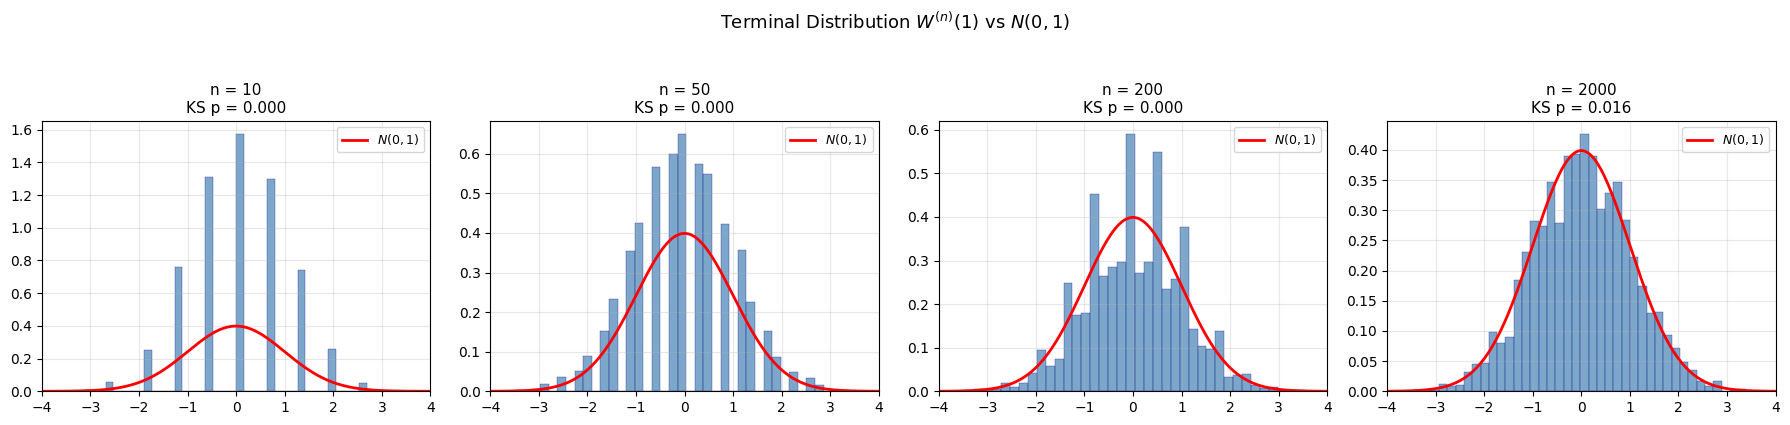

In [3]:
np.random.seed(123)

n_paths = 5000
t_eval = 1.0
n_values_dist = [10, 50, 200, 2000]

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
x_range = np.linspace(-4, 4, 200)
gaussian_pdf = stats.norm.pdf(x_range, 0, np.sqrt(t_eval))

for ax, n in zip(axes, n_values_dist):
    # Simulate n_paths independent random walks of length n
    steps = np.random.choice([-1, 1], size=(n_paths, n))
    endpoints = steps.sum(axis=1) / np.sqrt(n)
    
    ax.hist(endpoints, bins=40, density=True, color='steelblue', alpha=0.7,
            edgecolor='navy', linewidth=0.3)
    ax.plot(x_range, gaussian_pdf, 'r-', linewidth=2, label='$N(0,1)$')
    
    # KS test
    ks_stat, ks_p = stats.kstest(endpoints, 'norm')
    ax.set_title(f'n = {n}\nKS p = {ks_p:.3f}', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-4, 4)

plt.suptitle('Terminal Distribution $W^{(n)}(1)$ vs $N(0,1)$', fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

## Multiple Sample Paths of Brownian Motion

We now simulate true Brownian motion directly using Gaussian increments:
$$B_{t_{k+1}} = B_{t_k} + \sqrt{\Delta t} \, Z_k, \quad Z_k \sim \mathcal{N}(0,1)$$

Key features visible in the paths:
- **Irregularity:** paths are continuous but extremely rough
- **Symmetry:** paths wander above and below zero with equal likelihood
- **Spread grows as $\sqrt{t}$:** the $\pm 2\sqrt{t}$ envelope contains ~95% of paths

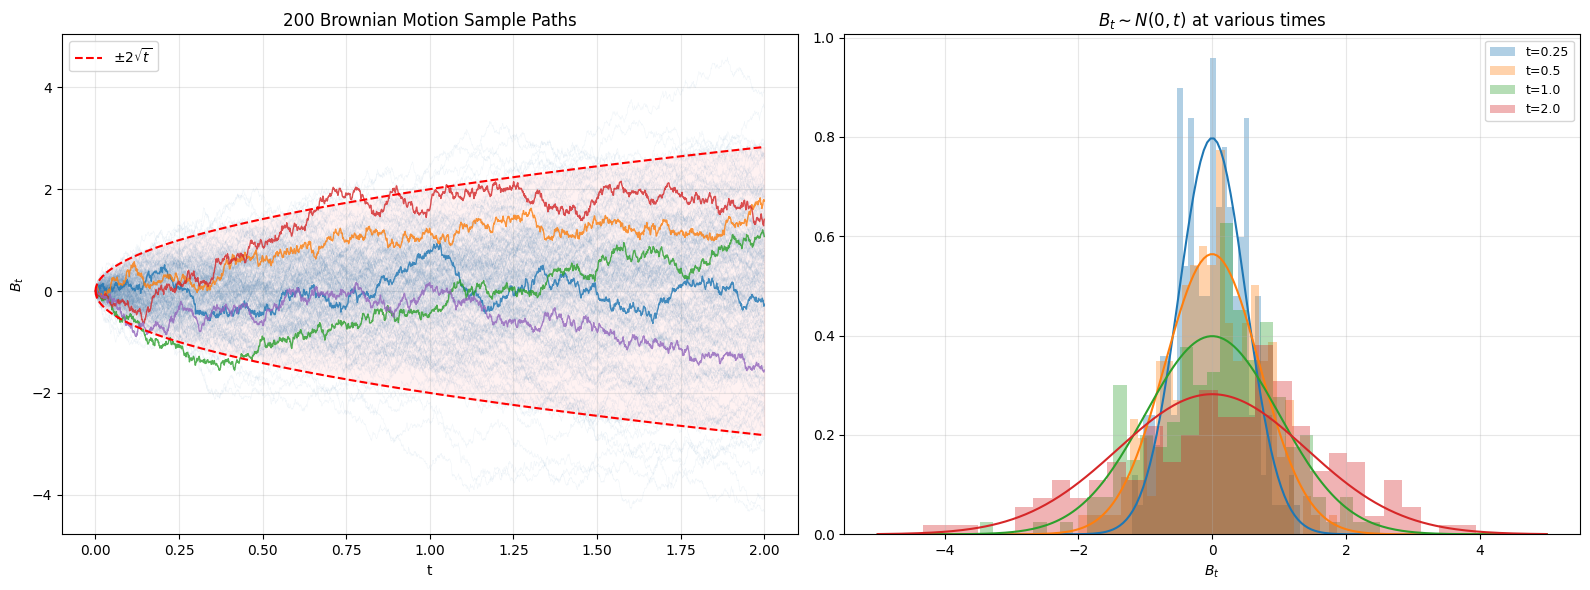

In [4]:
np.random.seed(2024)

T = 2.0
n_steps = 2000
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)
n_paths = 200

# Generate all paths at once
increments = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
paths = np.zeros((n_paths, n_steps + 1))
paths[:, 1:] = np.cumsum(increments, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: overlay many paths
for i in range(n_paths):
    ax1.plot(t_grid, paths[i], alpha=0.08, linewidth=0.4, color='steelblue')
# Highlight a few
for i in range(5):
    ax1.plot(t_grid, paths[i], alpha=0.8, linewidth=1.0)
# 95% envelope
envelope = 2 * np.sqrt(t_grid)
ax1.plot(t_grid, envelope, 'r--', linewidth=1.5, label='$\\pm 2\\sqrt{t}$')
ax1.plot(t_grid, -envelope, 'r--', linewidth=1.5)
ax1.fill_between(t_grid, -envelope, envelope, alpha=0.05, color='red')
ax1.set_xlabel('t'); ax1.set_ylabel('$B_t$')
ax1.set_title(f'{n_paths} Brownian Motion Sample Paths', fontsize=12)
ax1.legend(fontsize=10); ax1.grid(True, alpha=0.3)

# Right: distribution at several times
check_times = [0.25, 0.5, 1.0, 2.0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for t_val, color in zip(check_times, colors):
    idx = int(t_val / dt)
    vals = paths[:, idx]
    ax2.hist(vals, bins=30, density=True, alpha=0.35, color=color,
             label=f't={t_val}')
    x = np.linspace(-5, 5, 200)
    ax2.plot(x, stats.norm.pdf(x, 0, np.sqrt(t_val)), color=color, linewidth=1.5)
ax2.set_title('$B_t \\sim N(0,t)$ at various times', fontsize=12)
ax2.set_xlabel('$B_t$'); ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Levy Construction Intuition

The **Levy-Ciesielski construction** builds Brownian motion by refining a piecewise linear approximation on dyadic rationals. At level $k$, we add detail at the midpoints of existing intervals using the **Schauder basis** (hat functions):

$$B(t) = Z_0 \cdot t + \sum_{k=0}^{\infty} \sum_{j=0}^{2^k - 1} Z_{k,j} \cdot \psi_{k,j}(t)$$

where $\psi_{k,j}$ are scaled tent functions and $Z_{k,j} \sim \mathcal{N}(0,1)$.

Each refinement level adds finer detail. The series converges uniformly a.s., producing a continuous function.

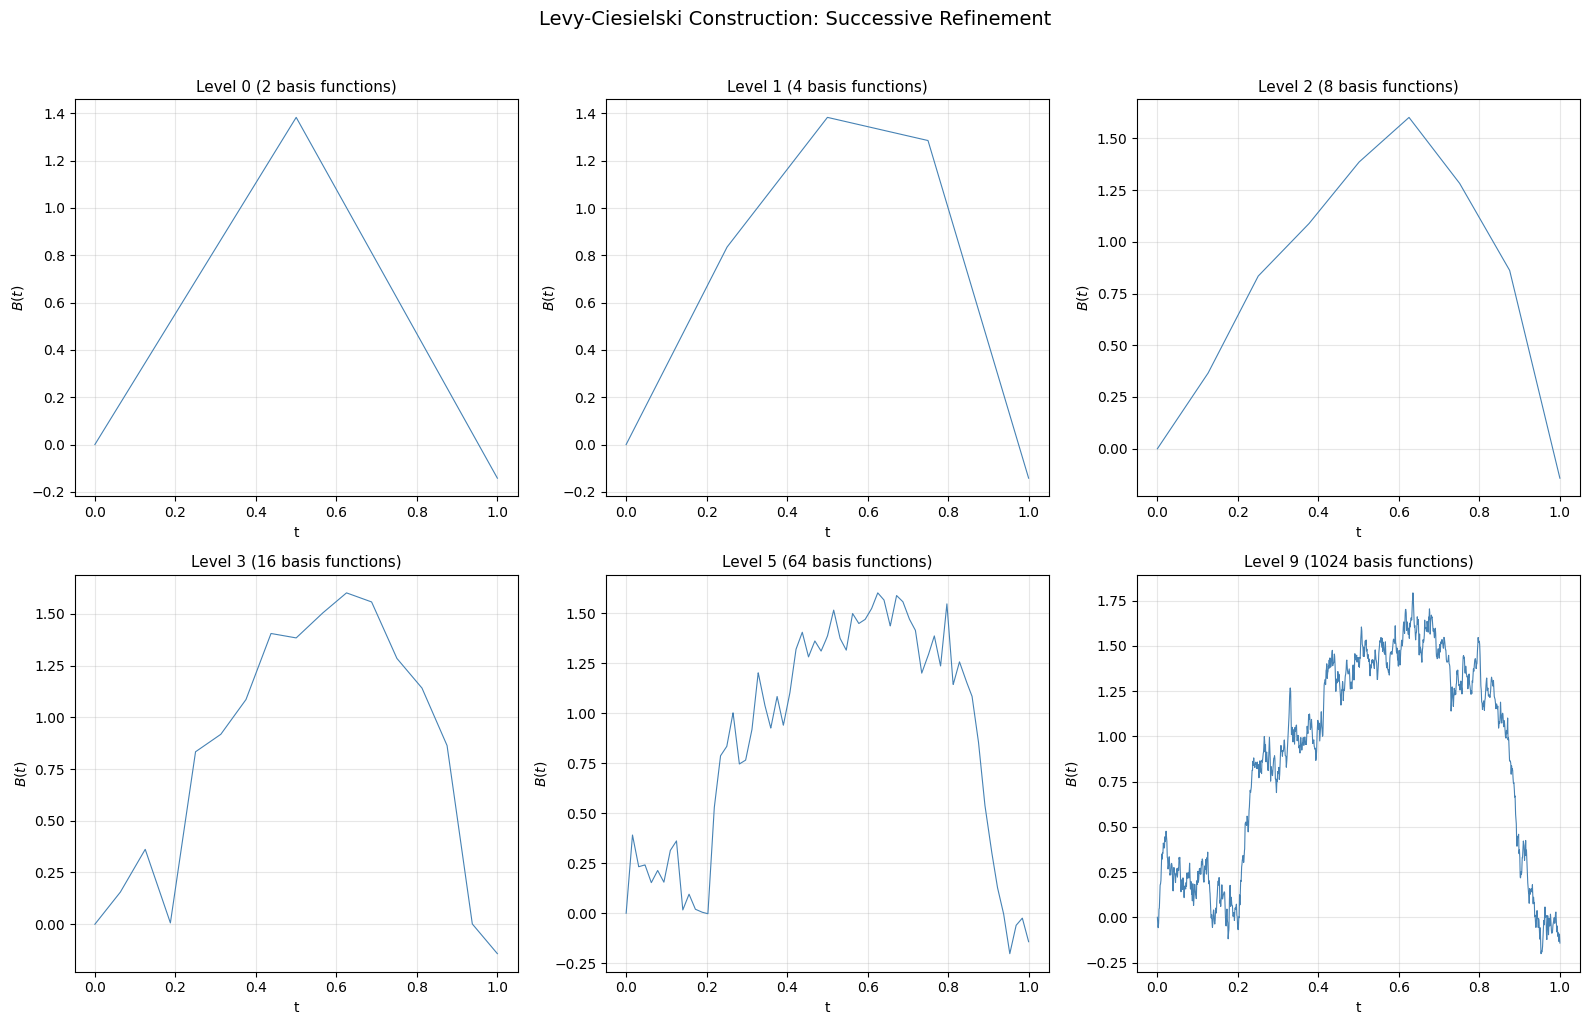

In [5]:
np.random.seed(99)

def schauder_function(k, j, t):
    """Schauder basis function psi_{k,j}(t) on [0,1]."""
    a = j / 2**k
    b = (j + 1) / 2**k
    mid = (a + b) / 2
    scale = 1.0 / 2**((k + 1) / 2)
    result = np.zeros_like(t)
    left = (t >= a) & (t <= mid)
    right = (t > mid) & (t <= b)
    result[left] = scale * 2 * (t[left] - a) / (b - a)
    result[right] = scale * 2 * (b - t[right]) / (b - a)
    return result

t = np.linspace(0, 1, 4000)
max_level = 10  # total levels for "true" path

# Pre-generate all random coefficients
Z0 = np.random.randn()  # coefficient for t
Z = {}
for k in range(max_level):
    for j in range(2**k):
        Z[(k, j)] = np.random.randn()

# Build approximations at increasing levels
display_levels = [0, 1, 2, 3, 5, max_level - 1]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for plot_idx, level in enumerate(display_levels):
    ax = axes[plot_idx]
    B_approx = Z0 * t
    for k in range(level + 1):
        for j in range(2**k):
            B_approx = B_approx + Z[(k, j)] * schauder_function(k, j, t)
    ax.plot(t, B_approx, linewidth=0.8, color='steelblue')
    n_basis = 1 + sum(2**k for k in range(level + 1))
    ax.set_title(f'Level {level} ({n_basis} basis functions)', fontsize=11)
    ax.set_xlabel('t'); ax.set_ylabel('$B(t)$')
    ax.grid(True, alpha=0.3)

plt.suptitle('Levy-Ciesielski Construction: Successive Refinement', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Increment Independence Verification

A defining property of Brownian motion is **independent increments**. For non-overlapping intervals $[s_1, t_1]$ and $[s_2, t_2]$, the increments $B_{t_1} - B_{s_1}$ and $B_{t_2} - B_{s_2}$ should be uncorrelated (and in fact independent, since they are jointly Gaussian).

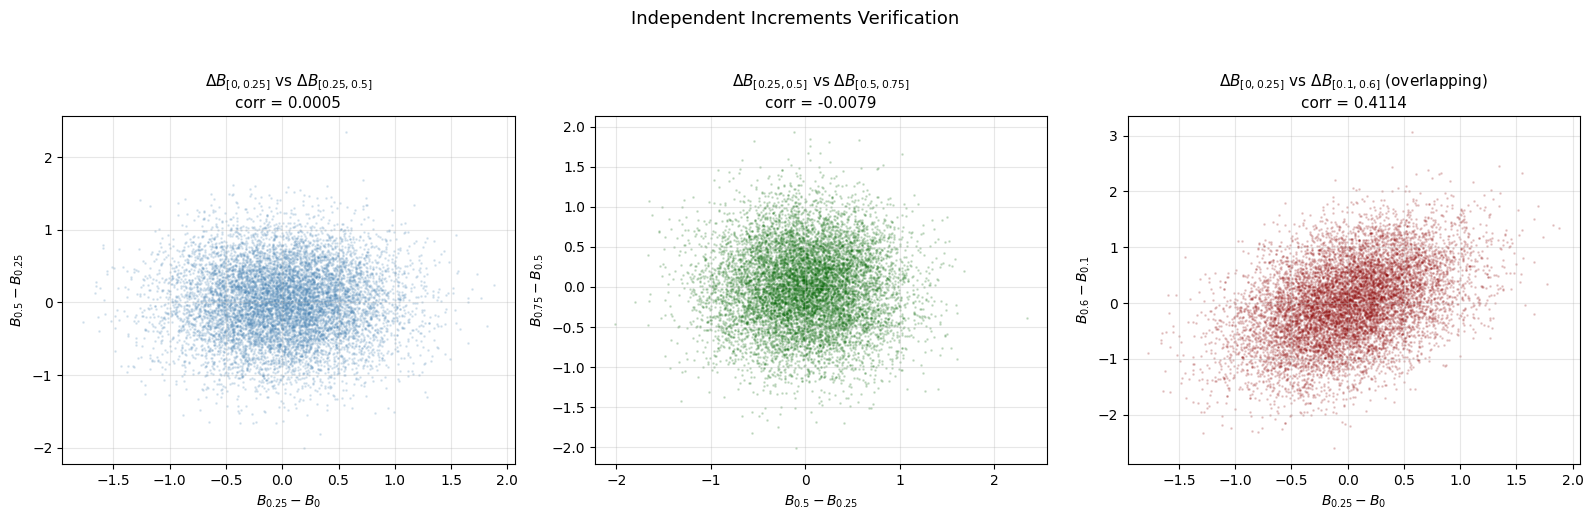

In [6]:
np.random.seed(314)

n_paths = 10000
n_steps = 1000
T = 1.0
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)

inc = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(inc, axis=1)

# Non-overlapping increments
inc1 = B[:, 250] - B[:, 0]        # B(0.25) - B(0)
inc2 = B[:, 500] - B[:, 250]      # B(0.50) - B(0.25)
inc3 = B[:, 750] - B[:, 500]      # B(0.75) - B(0.50)
# Overlapping increment for contrast
inc_overlap = B[:, 600] - B[:, 100]  # overlaps with inc1 and inc2

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Independent increments: should show no correlation
ax = axes[0]
ax.scatter(inc1, inc2, s=1, alpha=0.15, color='steelblue')
corr_12 = np.corrcoef(inc1, inc2)[0, 1]
ax.set_title(f'$\\Delta B_{{[0, 0.25]}}$ vs $\\Delta B_{{[0.25, 0.5]}}$\ncorr = {corr_12:.4f}', fontsize=11)
ax.set_xlabel('$B_{0.25} - B_0$'); ax.set_ylabel('$B_{0.5} - B_{0.25}$')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.scatter(inc2, inc3, s=1, alpha=0.15, color='darkgreen')
corr_23 = np.corrcoef(inc2, inc3)[0, 1]
ax.set_title(f'$\\Delta B_{{[0.25, 0.5]}}$ vs $\\Delta B_{{[0.5, 0.75]}}$\ncorr = {corr_23:.4f}', fontsize=11)
ax.set_xlabel('$B_{0.5} - B_{0.25}$'); ax.set_ylabel('$B_{0.75} - B_{0.5}$')
ax.grid(True, alpha=0.3)

# Overlapping: should show correlation
ax = axes[2]
ax.scatter(inc1, inc_overlap, s=1, alpha=0.15, color='darkred')
corr_ov = np.corrcoef(inc1, inc_overlap)[0, 1]
ax.set_title(f'$\\Delta B_{{[0, 0.25]}}$ vs $\\Delta B_{{[0.1, 0.6]}}$ (overlapping)\ncorr = {corr_ov:.4f}', fontsize=11)
ax.set_xlabel('$B_{0.25} - B_0$'); ax.set_ylabel('$B_{0.6} - B_{0.1}$')
ax.grid(True, alpha=0.3)

plt.suptitle('Independent Increments Verification', fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Donsker's theorem** guarantees that rescaled random walks $S_{\lfloor nt \rfloor}/\sqrt{n}$ converge in distribution to Brownian motion on path space $C[0,1]$.
2. **Sample paths** are continuous, erratic, and spread as $\pm\sqrt{t}$ -- the terminal value $B_t \sim N(0,t)$.
3. **Levy-Ciesielski construction** builds $B$ rigorously by summing Schauder basis functions with Gaussian coefficients; each level adds finer-scale fluctuations.
4. **Independent increments** are verified numerically: non-overlapping intervals yield near-zero correlation, while overlapping intervals show dependence.
5. The construction makes measure-theoretic existence precise: Brownian motion is a probability measure on $(C[0,1], \mathcal{B})$ satisfying the Kolmogorov consistency conditions.